In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as datetime
from bs4 import BeautifulSoup as bs
import requests
import sys
import folium
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

now = datetime.datetime.today()
ido = str(now.hour)+':'+str(now.minute)
now = str(now.month)+'/'+str(now.day)+'/'+str(now.year)[2:]


DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_C = "time_series_covid19_confirmed_global.csv"
FILE_D = "time_series_covid19_deaths_global.csv"
FILE_R = "time_series_covid19_recovered_global.csv"
country_table = {'United Kingdom': 'UK', 'United Arab Emirates': 'UAE', 'USA': 'US', 'Cote d\'Ivoire': 'Ivory Coast',
                 'Congo (Brazzaville)': 'Congo', 'Saint Vincent and the Grenadines': 'St. Vincent Grenadines',
                 'Korea, South': 'S. Korea', 'Taiwan*': 'Taiwan'}

f_c = pd.read_csv(DATA_URL+FILE_C)
f_d = pd.read_csv(DATA_URL+FILE_D)
f_r = pd.read_csv(DATA_URL+FILE_R)


In [2]:
def load_data(data, country):
    countries = []
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data.rename(columns={'country/region':'country', 'province/state':'state'}, inplace=True)
    data.fillna(0, inplace=True)
    countries.append(list(data['country']))
    data = data[data['country'] == country]
    if not data[data.state == 0].empty:
        data = data[data.state == 0]
    data = data.groupby(['country']).sum()
    data = data.iloc[:,4:].T
    data = data[(data.T != 0).any()]
    data.rename(columns={data.columns[0]: 'Case'}, inplace=True)
    return data, countries

def str2int(s):
    s = s.strip()
    if s == '' or s == 'N/A':
        return 0
    s = s.replace(',','')
    return int(s) 

In [3]:
the_country = 'Hungary'

In [4]:
df_d,_ = load_data(f_d, the_country) # Halottak
df_r,_ = load_data(f_r, the_country) # Gyógyultak
df_c,_ = load_data(f_c, the_country) # Esetek

df = pd.DataFrame()
df['Cases'] = df_c['Case']
df['Recovered'] = df_r['Case']
df['Dead'] = df_d['Case']

dfT = df.T
dfT.tail()

,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20
Cases,2.0,2.0,2.0,4.0,7.0,9.0,9.0,13.0,13.0,19.0,...,744.0,817.0,895.0,980.0,1190.0,1310.0,1410.0,1458.0,1512.0,1579.0
Recovered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,71.0,94.0,96.0,112.0,115.0,118.0,120.0,122.0,192.0
Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.0,47.0,58.0,66.0,77.0,85.0,99.0,109.0,122.0,134.0


In [5]:
if the_country == 'Hungary':
    url='https://koronavirus.gov.hu/'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    c = soup.find_all(class_ = 'number')
    eset = int(c[0].text.replace(' ',''))
    gyogyult = int(c[1].text.replace(' ',''))
    page = 0
    hl = []

    while True:
        try:
            url = f'https://koronavirus.gov.hu/elhunytak?page={page}'
            hp = pd.read_html(url)
            hl.append(hp[0])
            page += 1
        except:
            break

    hf = pd.DataFrame(hl[0])
    for x in range(1, len(hl)):
        hf = hf.append(pd.DataFrame(hl[x]))


    hf.drop(['Sorszám', 'Alapbetegségek'], axis=1, inplace = True)
    halott = hf.shape[0]
    avg_man = round(hf[hf['Nem'] == 'Férfi'].Kor.mean(),2)
    avg_wmn = round(hf[hf['Nem'] == 'Nő'].Kor.mean(),2)

    gr = hf.groupby(['Nem']).count()                    

    ages = lambda x: int(str(x)[:-1]+'0')
    hf['Kor'] = hf['Kor'].apply(ages)
    hf = hf.groupby(hf['Kor']).count()

    gr.rename(columns = {'Kor': 'Eset/Nem'}, inplace = True)
    hf.rename(columns = {'Nem': 'Eset/Korcsoport'}, inplace = True)

    
    dfT[now] = [eset, gyogyult, halott]
else:
    if the_country in country_table:
        the_country = country_table[the_country]

    url = 'https://www.worldometers.info/coronavirus/#countries'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    tbl = soup.find(id='main_table_countries_today')
    tbl = tbl.findAll('tr')
    eset = -1
    for tr in tbl:
        if the_country in tr.text:
            tds = tr.findAll('td')
            eset = str2int(tds[1].text)
            halott = str2int(tds[3].text)
            gyogyult = str2int(tds[5].text)
            break
    if eset > -1:
        dfT[now] = [eset, gyogyult, halott]
    else:
        print(f'{the_country} is not on [page]({url}).')
df.tail()

,Cases,Recovered,Dead
4/11/20,1310,115.0,85.0
4/12/20,1410,118.0,99.0
4/13/20,1458,120.0,109.0
4/14/20,1512,122.0,122.0
4/15/20,1579,192.0,134.0


In [6]:
df = dfT.T
df.fillna(0, inplace= True)
df['Active'] = df['Cases']-df['Recovered'] - df['Dead']

df = df.reset_index()
df.rename(columns = {'index': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'], drop=True, inplace=True)

df['Active'] = df['Cases']-(df['Recovered']+df['Dead'])
df['Cases+'] = df['Cases'].shift(1)
df['Dead+'] = df['Dead'].shift(1)
df['Recovered+'] = df['Recovered'].shift(1)
df.fillna(0, inplace=True)
df['Cases/day'] = abs(df['Cases'] - df['Cases+'])
df['Deads/day'] = abs(df['Dead'] - df['Dead+'])
df['Recovered/day'] = abs(df['Recovered'] - df['Recovered+'])

df.drop(['Cases+', 'Dead+', 'Recovered+'], axis=1, inplace=True)
df = df.astype(int)

m_cases = df['Cases'].iloc[-1]
m_recovered = df['Recovered'].iloc[-1]
m_dead = df['Dead'].iloc[-1]
m_active = df['Active'].iloc[-1]
df.tail()

,Cases,Recovered,Dead,Active,Cases/day,Deads/day,Recovered/day
Date,,,,,,,
2020-04-12,1410,118,99,1193,100,14,3
2020-04-13,1458,120,109,1229,48,10,2
2020-04-14,1512,122,122,1268,54,13,2
2020-04-15,1579,192,134,1253,67,12,70
2020-04-16,1652,199,142,1311,73,8,7


Image saved as: hungary.png


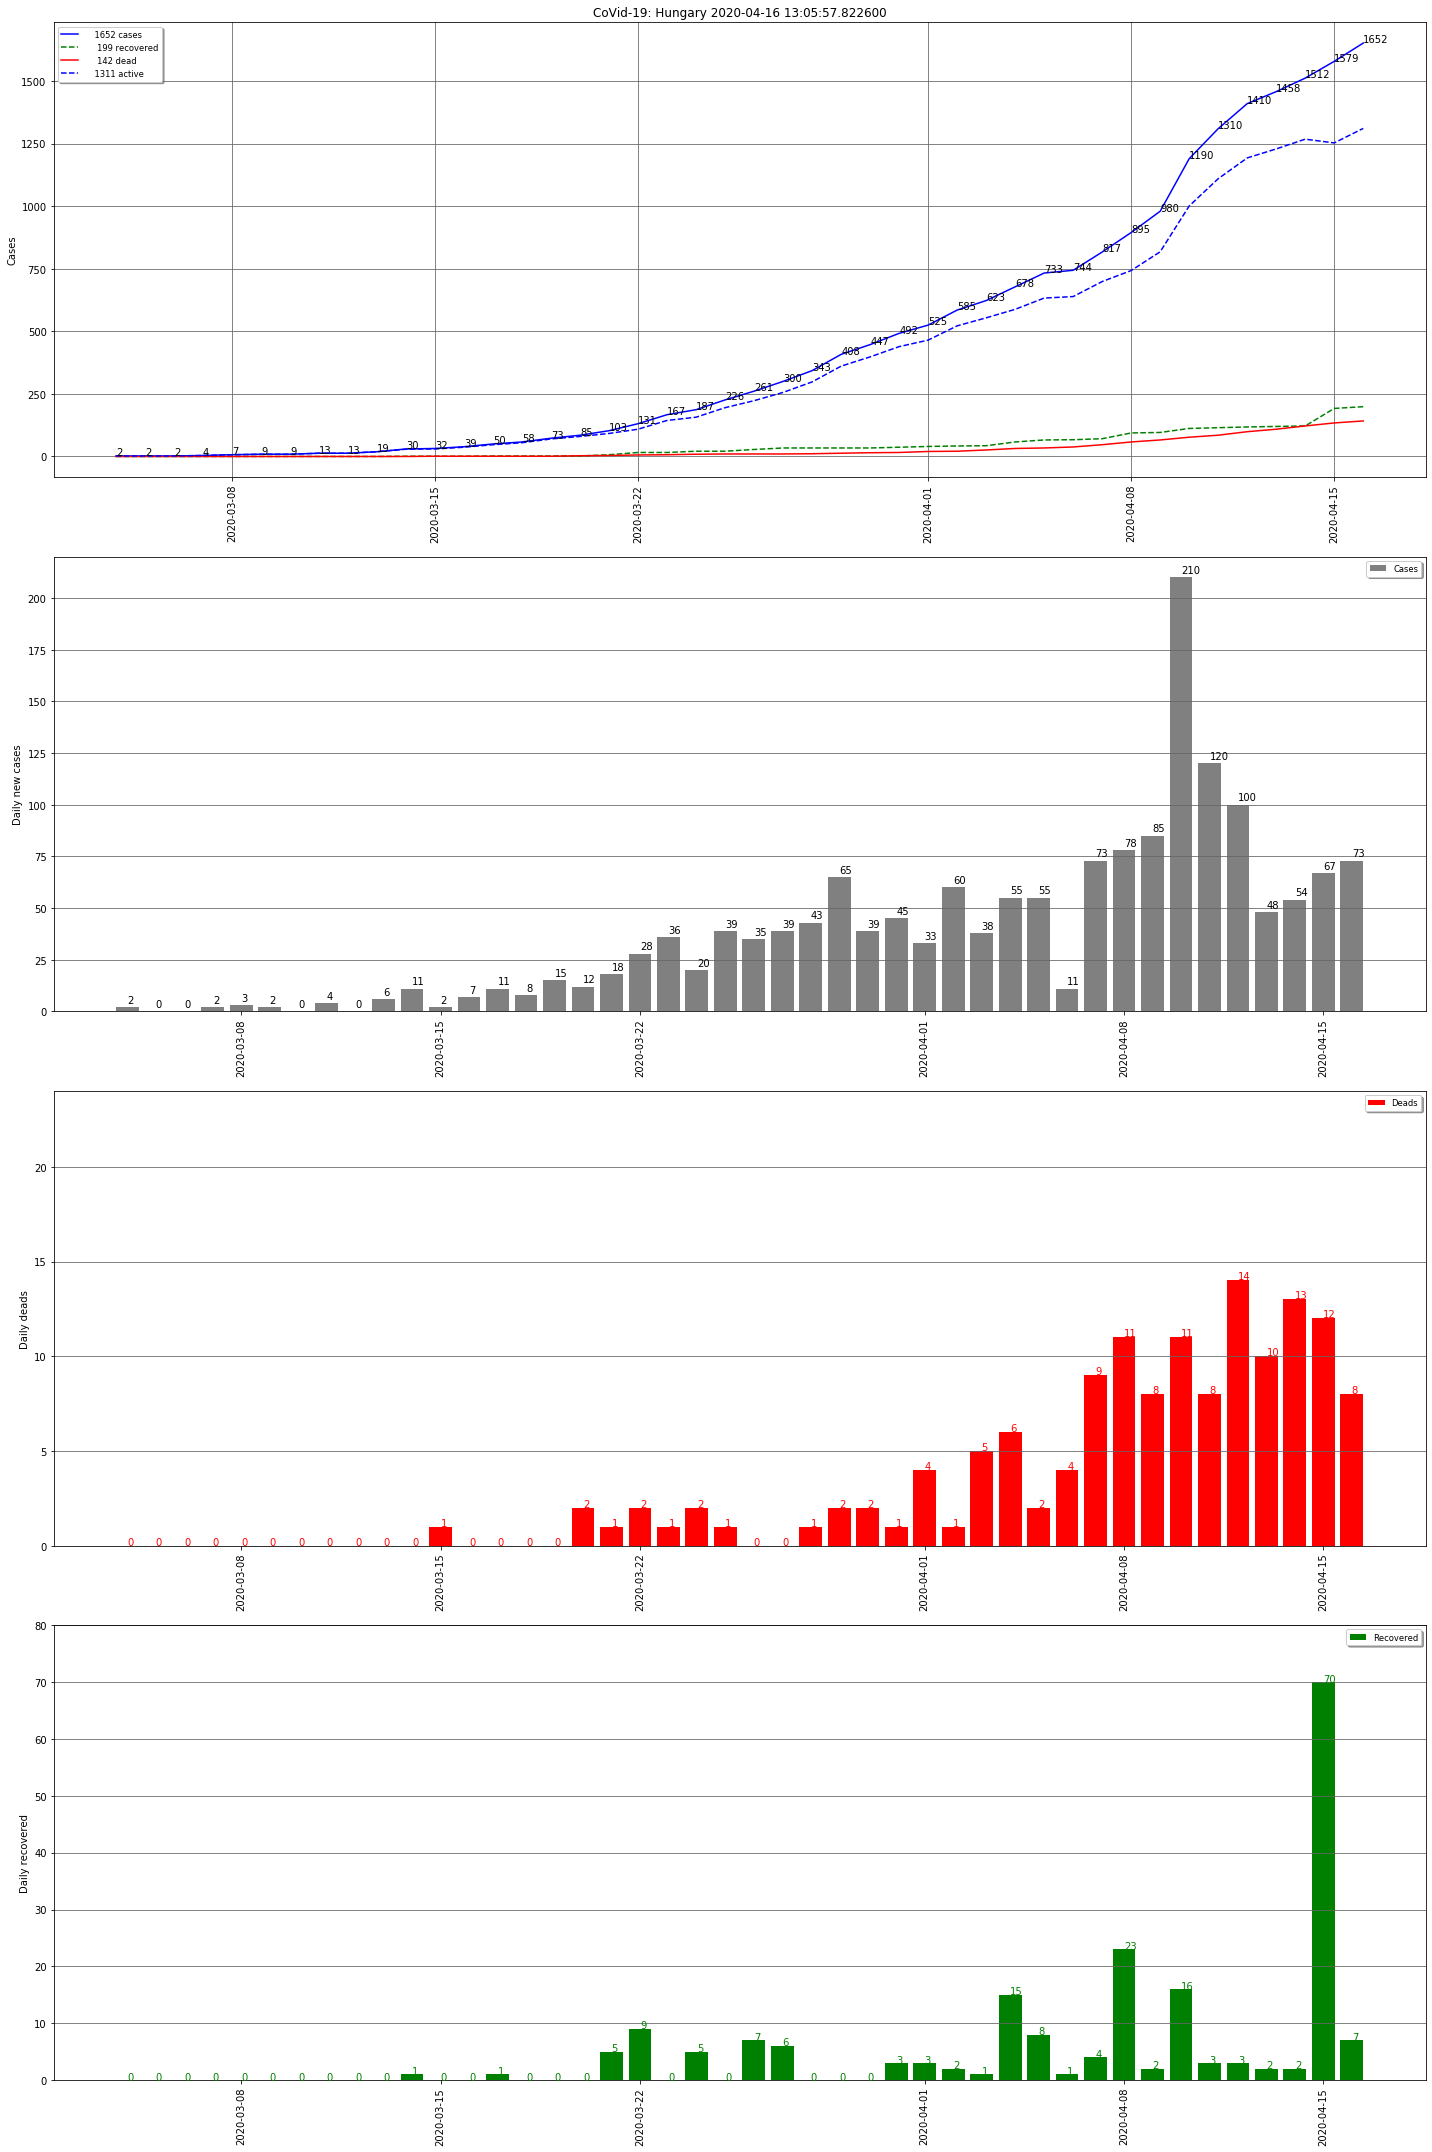

In [7]:
plt.figure(figsize=(20,30), tight_layout=True)

ax = plt.subplot(411, frameon=True)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df.index, df['Cases'], 'b-',     label=f"{df['Cases'].max():8} cases")
plt.plot(df.index, df['Recovered'], 'g--', label=f"{df['Recovered'].max():8} recovered")
plt.plot(df.index, df['Dead'], 'r-',    label=f"{df['Dead'].max():8} dead")
plt.plot(df.index, df['Active'], 'b--',    label=f"{df['Active'].max():8} active")

for i,j in df.Cases.items():
    ax.annotate(str(j), xy=(i, j + 2))

plt.ylabel('Cases')
plt.title(f'CoVid-19: {the_country} {datetime.datetime.today()}')
plt.legend(shadow=True, fontsize='small')
plt.xticks(rotation='vertical')

bx = plt.subplot(412, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.bar(df.index, df['Cases/day'], label='Cases', color='gray')
plt.ylabel('Daily new cases')
plt.ylim(0,df['Cases/day'].max() + 10)
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Cases/day'].items():
    bx.annotate(j, xy=(i, j + 2))
    
cx = plt.subplot(413, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.ylabel('Daily deads')
plt.ylim(0,df['Deads/day'].max() + 10)
plt.bar(df.index, df['Deads/day'], label='Deads', color='red')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Deads/day'].items():
    cx.annotate(j, xy=(i, j + 0.05), color='red')


dx = plt.subplot(414, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.ylabel('Daily recovered')
plt.ylim(0,df['Recovered/day'].max() + 10)
plt.bar(df.index, df['Recovered/day'], label='Recovered', color='green')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df['Recovered/day'].items():
    dx.annotate(j, xy=(i, j + 0.05), color='green')


plt.savefig(f'{the_country.lower()}.png')
print(f'Image saved as: {the_country.lower()}.png')



Férfi: 57.04%
Nő: 42.96%


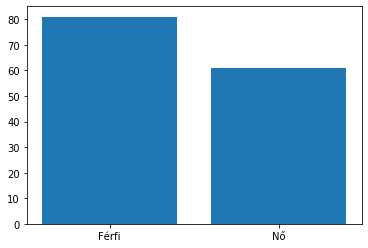

In [8]:
if the_country == 'Hungary':

    print(f"Férfi: {round(gr['Eset/Nem'][0]/m_dead*100,2)}%\nNő: {round(gr['Eset/Nem'][1]/m_dead*100,2)}%")
    plt.bar(gr.index, gr['Eset/Nem'])

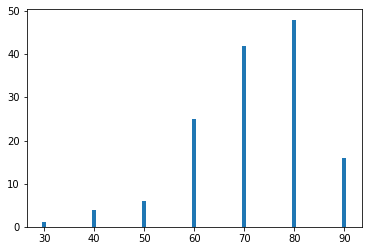

In [9]:
if the_country == 'Hungary':    
    hf.reset_index(inplace=True)
    plt.bar(hf['Kor'], hf['Eset/Korcsoport'], align='center')

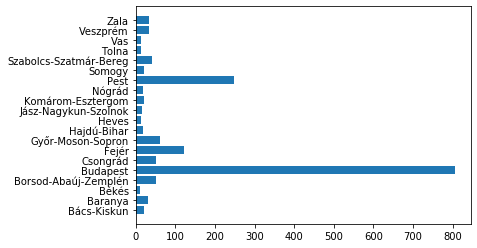

In [10]:
url = 'https://raw.githubusercontent.com/mollac/CoVid-19/master/korona_megyei.csv'
df = pd.read_csv(url, sep=';', encoding='utf-8')
df = df.set_index('Dátum', drop = True)   
df = df.T.iloc[:,-1]
df.columns = ['eset']
plt.barh(df.index, df)
plt.show()

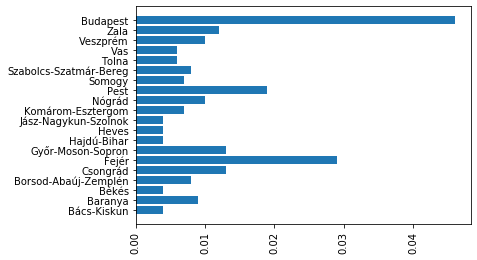

In [11]:
url = r'https://hu.wikipedia.org/wiki/Magyarorsz%C3%A1g_megy%C3%A9i'
dl = pd.read_html(url, encoding='utf-8')
mf = pd.DataFrame(dl[0][['Megye','Népesség']])
mf.dropna(inplace = True)
mf.T.loc['Megye',20] = 'Budapest'
mf.columns = ['megye', 'lakos']
mf.set_index('megye', drop = True, inplace = True)
st = lambda x: int(x.replace('\xa0',''))
mf['lakos'] = mf['lakos'].apply(st)
mf['eset'] = df
mf['százalék'] = round(mf.eset / mf.lakos * 100,3)
plt.xticks(rotation='vertical')
plt.barh(mf.index, mf['százalék'])
plt.show()

In [12]:
hungary = [46.98, 18.97]
url = 'https://raw.githubusercontent.com/mollac/CoVid-19/master/megye_koord.csv'
df = pd.read_csv(url)
df['eset'] = list(mf['eset'])
df

,megye,lat,lon,eset
0,Bács-Kiskun,46.568638,19.382235,22
1,Baranya,46.035982,18.208911,32
2,Békés,46.773510,21.133650,12
3,Borsod-Abaúj-Zemplén,48.198550,20.971621,50
4,Csongrád,46.426751,20.235191,52
5,Fejér,47.129255,18.536119,122
6,Győr-Moson-Sopron,47.641349,17.279517,62
7,Hajdú-Bihar,47.470271,21.457257,19
8,Heves,47.786118,20.193716,13
9,Jász-Nagykun-Szolnok,47.262302,20.420204,16


In [13]:
lats = list(df.lat)
lons = list(df.lon)
cases = list(df.eset)
names = list(df.megye)
map = folium.Map(location=hungary, zoom_start=7, control_scale=True)
for lat, lon, eset, name in zip(lats, lons, cases, names):
    html = f'<h4>{str(name)}</h4><p>Eset: <b>{eset}</b></p>'
    map.add_child(folium.Circle(location=[lat, lon], 
                                popup=html, 
                                radius = eset*20, 
                                color='#aa0000', 
                                fill_color='#ff0000', 
                                fill_opacity=0.3,
                                fill=True))
map